In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv("/content/US_Crime_DataSet.csv")
print("Initial shape:", df.shape)

Initial shape: (219422, 24)


In [ ]:
for col in ['Victim Age', 'Perpetrator Age']:
    df[col] = df[col].replace(['Unknown', '0'], np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
df.dropna(subset=['Victim Age', 'Perpetrator Age'], inplace=True)

In [ ]:
df['Year'] = df['Year'].astype(int)
print("After age cleaning:", df.shape)

After age cleaning: (219421, 24)


In [ ]:
print(df["Crime Solved"].value_counts())

Crime Solved
Yes    159528
No      59893
Name: count, dtype: int64


In [ ]:
def detect_and_remove_outliers_iqr(df, column, multiplier=2.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

for col in ['Victim Age', 'Perpetrator Age']:
    df = detect_and_remove_outliers_iqr(df, col)

print("After outlier removal:", df.shape)
print(df["Crime Solved"].value_counts())

After outlier removal: (213073, 24)
Crime Solved
Yes    156346
No      56727
Name: count, dtype: int64


/tmp/ipython-input-8-3523625076.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Crime Solved', palette='Set2')


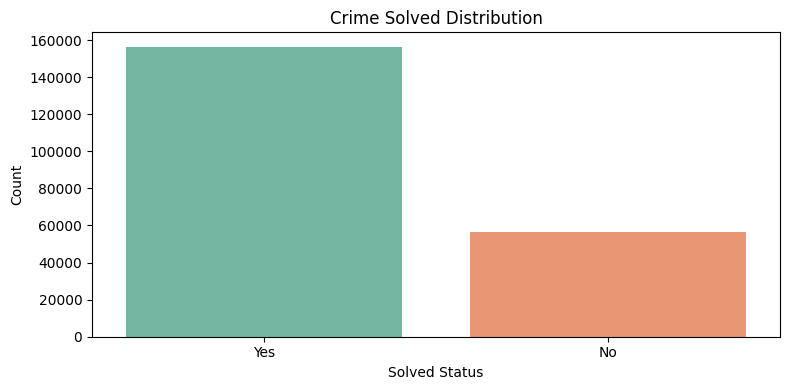

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Crime Solved', palette='Set2')
plt.title('Crime Solved Distribution')
plt.xlabel('Solved Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

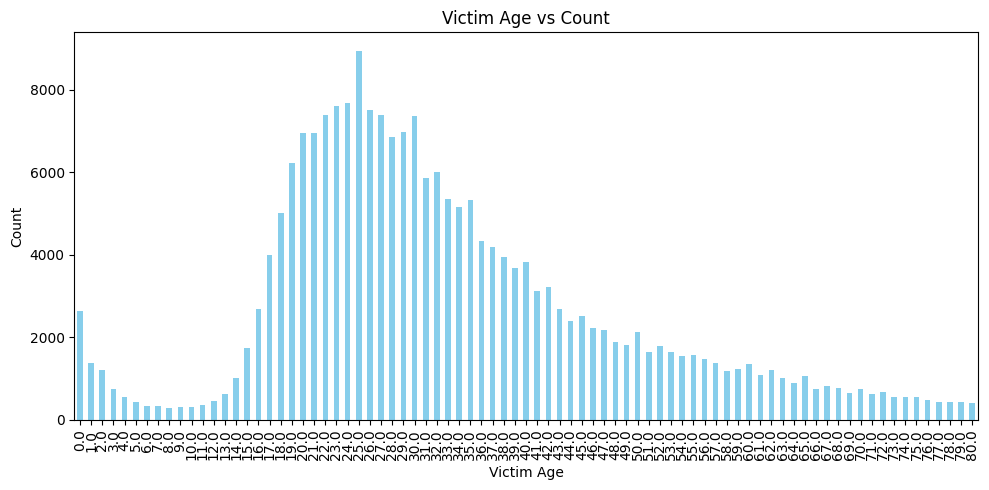

In [ ]:
plt.figure(figsize=(10, 5))
df['Victim Age'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Victim Age vs Count')
plt.xlabel('Victim Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

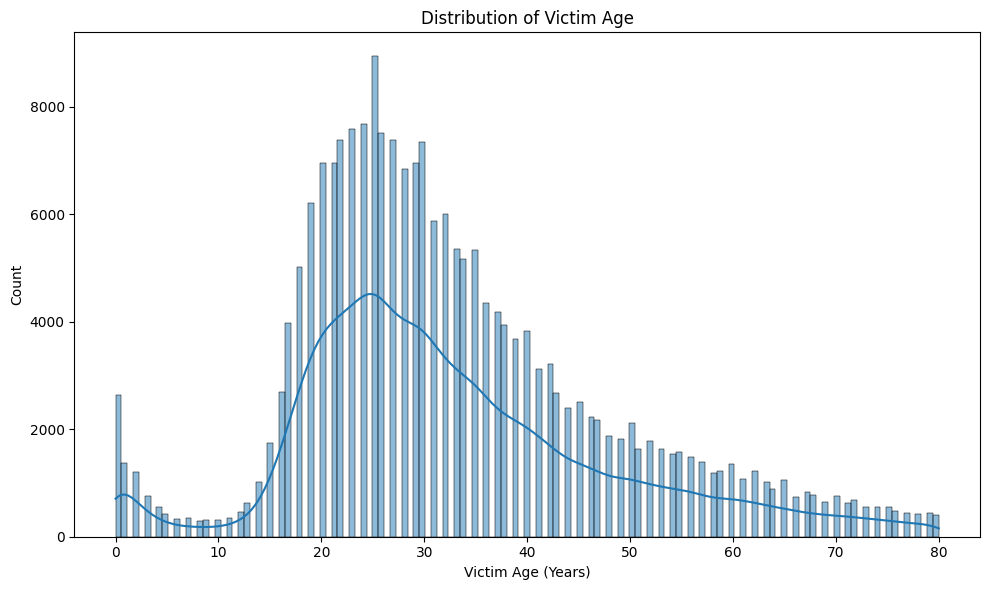

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Victim Age', bins='auto', kde=True)
plt.title('Distribution of Victim Age')
plt.xlabel('Victim Age (Years)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

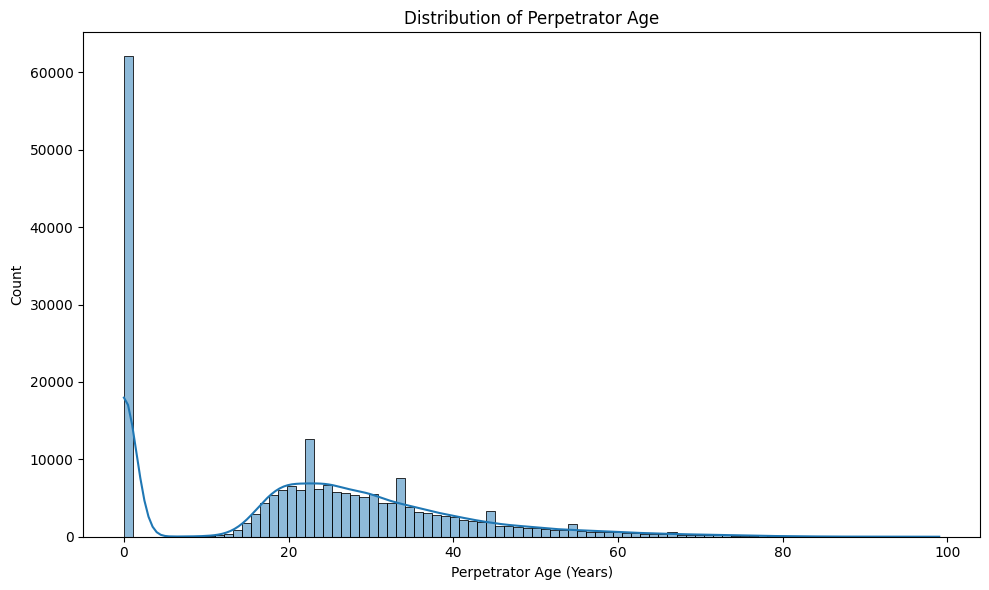

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Perpetrator Age', bins='auto', kde=True)
plt.title('Distribution of Perpetrator Age')
plt.xlabel('Perpetrator Age (Years)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

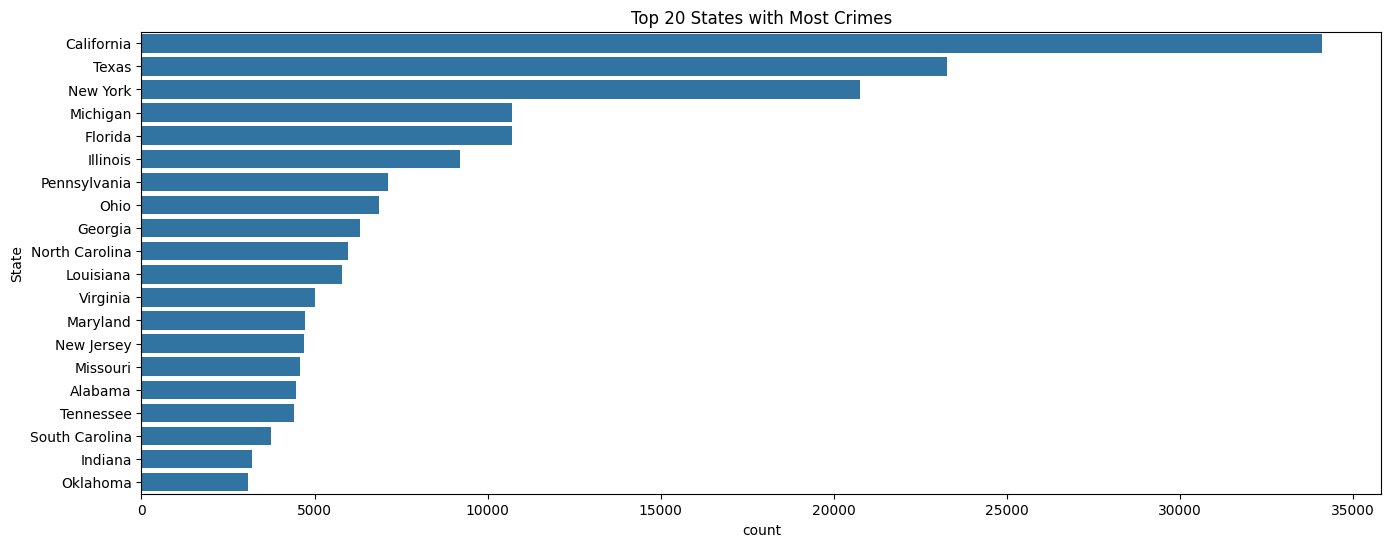

In [ ]:
plt.figure(figsize=(16, 6))
sns.countplot(data=df, y='State', order=df['State'].value_counts().index[:20])
plt.title('Top 20 States with Most Crimes')
plt.show()

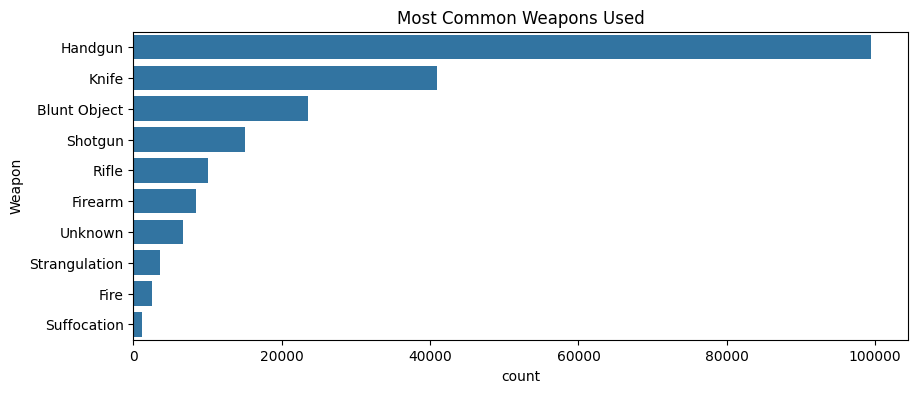

In [ ]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, y='Weapon', order=df['Weapon'].value_counts().index[:10])
plt.title('Most Common Weapons Used')
plt.show()

In [ ]:
def detect_and_remove_outliers_iqr_plot(df, column):
    plt.figure(figsize=(10, 5))


    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[column], color='orange')
    plt.title(f'{column} - Before Outlier Removal')


    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clean = df[(df[column] >= lower) & (df[column] <= upper)]


    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean[column], color='green')
    plt.title(f'{column} - After Outlier Removal')

    plt.tight_layout()
    plt.show()

    return df_clean


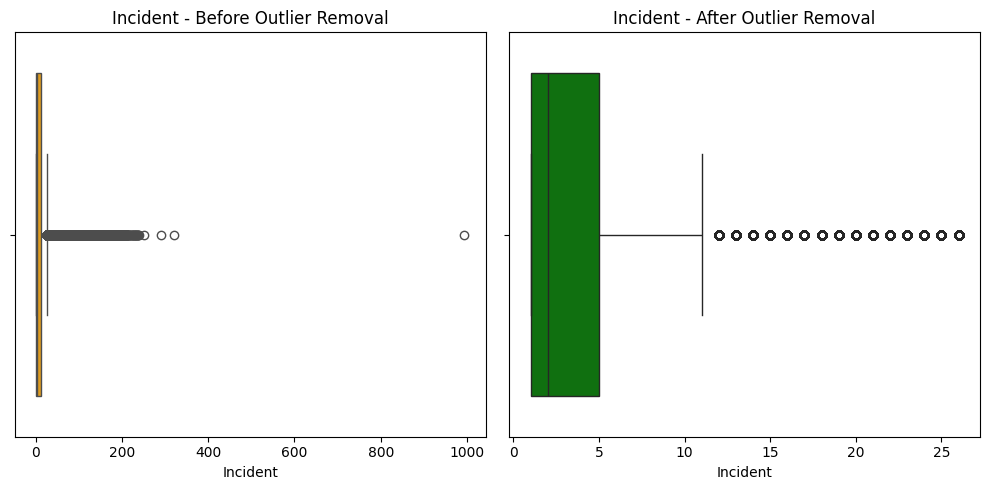

In [ ]:
df = detect_and_remove_outliers_iqr_plot(df, 'Incident')

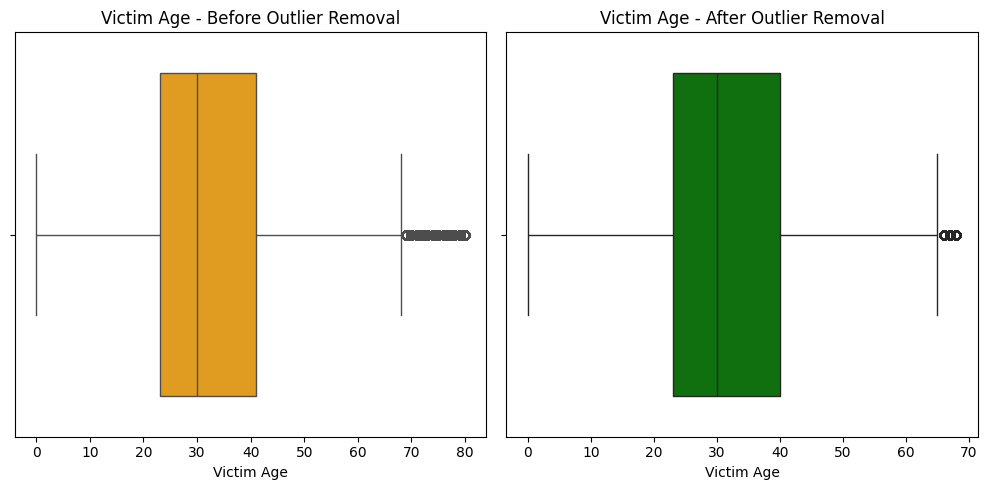

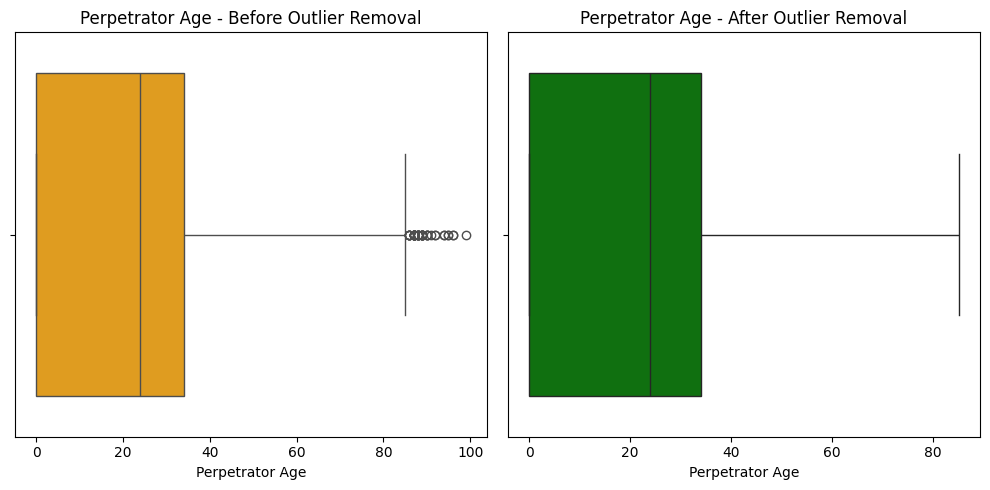

In [ ]:
df = detect_and_remove_outliers_iqr_plot(df, 'Victim Age')
df = detect_and_remove_outliers_iqr_plot(df, 'Perpetrator Age')

In [ ]:
agg_df = df.groupby(['State', 'Year']).agg({
    'Incident': 'count',
    'Victim Age': 'mean',
    'Perpetrator Age': 'mean',
    'Victim Sex': lambda x: x.mode()[0],
    'Perpetrator Sex': lambda x: x.mode()[0],
    'Weapon': lambda x: x.mode()[0],
    'Agency Type': lambda x: x.mode()[0],
    'Crime Solved': lambda x: (x == 'Yes').mean()
}).reset_index()

agg_df.rename(columns={
    'Incident': 'Total Crimes',
    'Crime Solved': 'Solved Ratio'
}, inplace=True)

In [ ]:
threshold = agg_df['Total Crimes'].quantile(0.7)
agg_df['High Crime Risk'] = (agg_df['Total Crimes'] >= threshold).astype(int)

In [ ]:
le = LabelEncoder()
for col in ['Victim Sex', 'Perpetrator Sex', 'Weapon', 'Agency Type']:
    agg_df[col] = le.fit_transform(agg_df[col])

X = agg_df.drop(['State', 'Total Crimes', 'High Crime Risk'], axis=1)
y = agg_df['High Crime Risk']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
pip install xgboost

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("\n Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       122
           1       0.55      0.53      0.54        45

    accuracy                           0.75       167
   macro avg       0.69      0.68      0.69       167
weighted avg       0.75      0.75      0.75       167



In [ ]:
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
print("\n Logistic Regression Report:")
print(classification_report(y_test, lr_preds))


 Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.81       122
           1       0.31      0.11      0.16        45

    accuracy                           0.69       167
   macro avg       0.52      0.51      0.49       167
weighted avg       0.62      0.69      0.64       167



In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("\n XGBoost Classifier Report:")
print(classification_report(y_test, xgb_preds))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:02:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       122
           1       0.57      0.53      0.55        45

    accuracy                           0.77       167
   macro avg       0.70      0.69      0.70       167
weighted avg       0.76      0.77      0.76       167



In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
print("\n K-Nearest Neighbors Report:")
print(classification_report(y_test, knn_preds))


 K-Nearest Neighbors Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       122
           1       0.54      0.64      0.59        45

    accuracy                           0.75       167
   macro avg       0.70      0.72      0.71       167
weighted avg       0.77      0.75      0.76       167



In [ ]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("\n Support Vector Machine Report:")
print(classification_report(y_test, svm_preds))


 Support Vector Machine Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       122
           1       0.55      0.36      0.43        45

    accuracy                           0.75       167
   macro avg       0.67      0.62      0.64       167
weighted avg       0.73      0.75      0.73       167



In [ ]:
models = {
    "Random Forest": accuracy_score(y_test, rf_preds),
    "Logistic Regression": accuracy_score(y_test, lr_preds),
    "XGBoost": accuracy_score(y_test, xgb_preds),
    "KNN": accuracy_score(y_test, knn_preds),
    "SVM": accuracy_score(y_test, svm_preds)
}

/tmp/ipython-input-29-3278513201.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models.values()), y=list(models.keys()), palette="viridis")


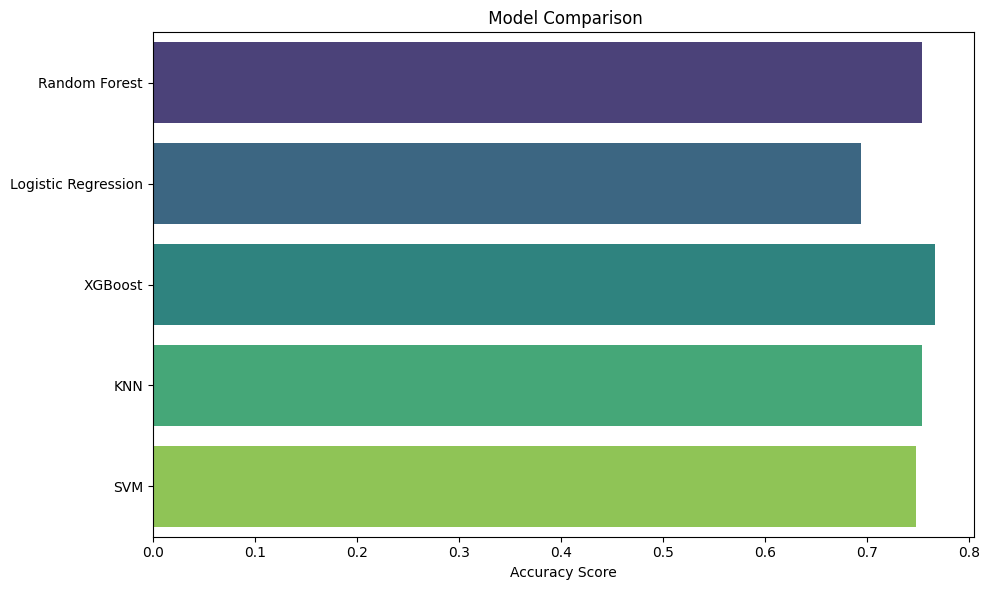

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(models.values()), y=list(models.keys()), palette="viridis")
plt.xlabel("Accuracy Score")
plt.title(" Model Comparison")
plt.tight_layout()
plt.show()

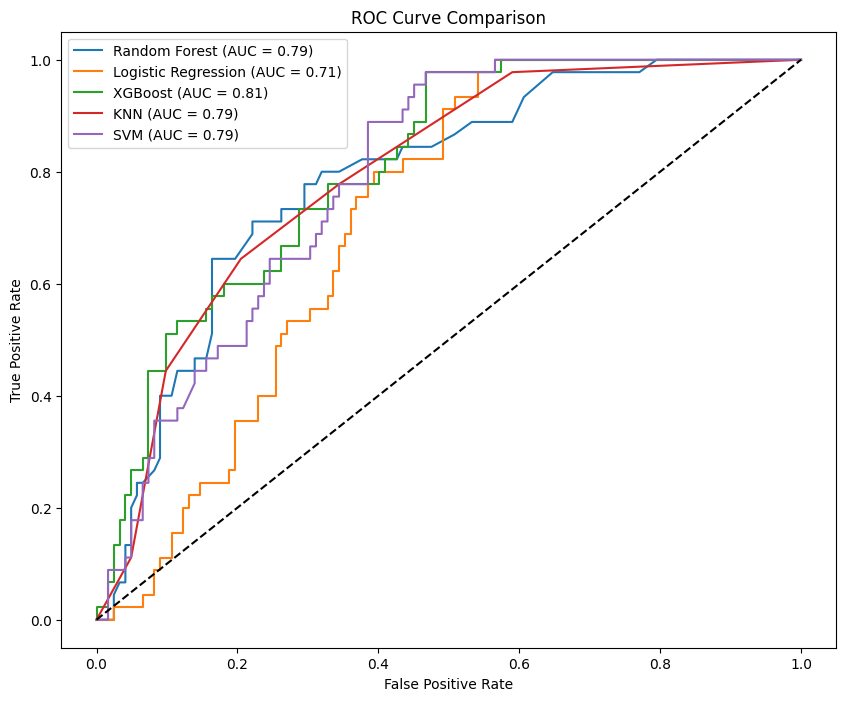

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# For ROC Curves (only works for binary classification)
models_list = [
    ('Random Forest', rf_model),
    ('Logistic Regression', lr_model),
    ('XGBoost', xgb_model),
    ('KNN', knn_model),
    ('SVM', svm_model)
]

plt.figure(figsize=(10, 8))
for name, model in models_list:
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        continue  # Skip models without predict_proba
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [ ]:
import joblib

In [ ]:
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(lr_model, "lr_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(knn_model, "knn_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
agg_df.to_csv("/content/processed_agg_df.csv", index=False)

In [ ]:
pip install gradio

In [ ]:
import gradio as gr
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load models and scaler if needed (not used directly here, but could be extended)
scaler = joblib.load("scaler.pkl")

# Load preprocessed data
df = pd.read_csv("/content/US_Crime_DataSet.csv")

# Clean same as in training pipeline
df['Victim Age'] = pd.to_numeric(df['Victim Age'].replace(['Unknown', '0', 0], pd.NA), errors='coerce')
df['Perpetrator Age'] = pd.to_numeric(df['Perpetrator Age'].replace(['Unknown', '0', 0], pd.NA), errors='coerce')
df = df.dropna(subset=['Victim Age', 'Perpetrator Age'])
df['Year'] = df['Year'].astype(int)

# Function to get state-level stats
def state_crime_summary(selected_state):
    state_df = df[df['State'] == selected_state]

    total_crimes = len(state_df)
    solved_ratio = (state_df['Crime Solved'] == 'Yes').mean() * 100
    avg_victim_age = state_df['Victim Age'].mean()
    avg_perp_age = state_df['Perpetrator Age'].mean()
    common_weapon = state_df['Weapon'].mode()[0] if not state_df['Weapon'].mode().empty else "N/A"

    # Create visual
    plt.figure(figsize=(6, 3))
    sns.countplot(data=state_df, x='Crime Type', order=state_df['Crime Type'].value_counts().index[:5], palette='magma')
    plt.title(f"Top Crime Types in {selected_state}")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plot_path = "state_crime_plot.png"
    plt.savefig(plot_path)
    plt.close()

    summary = (
        f" **State**: {selected_state}\n"
        f" **Total Crimes**: {total_crimes}\n"
        f" **Crime Solved Rate**: {solved_ratio:.2f}%\n"
        f" **Avg Victim Age**: {avg_victim_age:.1f}\n"
        f" **Avg Perpetrator Age**: {avg_perp_age:.1f}\n"
        f"**Most Common Weapon**: {common_weapon}"
    )

    return summary, plot_path

# List of available states
state_list = sorted(df['State'].unique())

# Interface
with gr.Blocks(theme=gr.themes.Soft()) as dashboard:
    gr.Markdown("##  US Crime Insight Dashboard")
    gr.Markdown("Select a US state to explore its crime profile ")

    with gr.Row():
        state_dropdown = gr.Dropdown(choices=state_list, label="Select a State")
        output_summary = gr.Markdown()

    output_plot = gr.Image(type="filepath", label="Top Crimes Visual")

    state_dropdown.change(fn=state_crime_summary, inputs=state_dropdown, outputs=[output_summary, output_plot])

dashboard.launch()

/tmp/ipython-input-35-3990018658.py:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/US_Crime_DataSet.csv")
/tmp/ipython-input-35-3990018658.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Year'].astype(int)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0f7523c224a4fd82e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
